<a href="https://colab.research.google.com/github/berry2971/senti-dict-yes24/blob/master/senti_dict_yes24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

-Primary References & Tool-

Van der Maaten, L.J.P., Hinton, G.E. (2008), "Visualizing Data Using t-SNE"

Song S. I., D. J. Lee and S. G. Lee. (2010), "Identifying Sentiment Polarity of Korean Vocabulary Using PMI"

이상훈·최정·김종우(2016), "영역별 맞춤형 감성사전 구축을 통한 영화리뷰 감성분석"

gensim Word2Vec model

In [0]:
##### Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
##### Connect with db (raw text)
import sqlite3
con1 = sqlite3.connect('/content/gdrive/My Drive/senti/result_yes24.db')
cur1 = con1.cursor()

In [0]:
##### Connect with db (analyzed text)
con2 = sqlite3.connect('/content/gdrive/My Drive/senti/result_yes24_tagged.db')
con2.execute('CREATE TABLE analysis (TAGGED BLOB, REVIEW_STAR_CONTENT INTEGER, REVIEW_STAR_EDITION INTEGER)')

In [0]:
########## EXECUTE FIRST TIME ONLY ##########
##### Prepare pos tagger: mecab
!pip install -v python-mecab-ko
import mecab
mecab = mecab.MeCab()

In [0]:
########## EXECUTE FIRST TIME ONLY ##########
##### Prepare sentence divider: kss(Korean Sentence Splitter by 박상길)
!pip install kss
import kss

'''
raw = "안녕하세요. 오늘은 날씨가 맑네요! 하늘도 푸르구요! 미세먼지만 없으면ㅠㅠ 좋을텐데ㅠㅠ"
kss.split_sentences(raw)
'''

In [0]:
########## SPENDS LONG TIME ##########
########## EXECUTE FIRST TIME ONLY ##########
##### Pos tag and save it into database
import pickle

count = 0
for row in cur1.execute("SELECT review_content, review_star_content, review_star_edition FROM reviews"):
    # Insert pickled data into database
    tagged_sentences = [mecab.pos(sentence) for sentence in kss.split_sentences(row[0])] # data
    data = tagged_sentences
    pdata = pickle.dumps(data)
    con2.execute('INSERT INTO analysis (TAGGED, REVIEW_STAR_CONTENT, REVIEW_STAR_EDITION) VALUES (?, ?, ?)', [pdata, row[1], row[2]])
  
    # Check progress and Commit database
    count += 1
    if count % 1000 == 0:
        print(count)
        con2.commit()

con2.commit()

In [0]:
##### Load database
import pickle

con3 = con2
cur3 = con3.cursor()

posv_sentences = []
negv_sentences = [] # [[(안녕, IC), (하, NNP), (시어요, EP+EF)], [(그렇, VA), (구나, EF)]]]
count_posv_sentences = 0
count_negv_sentences = 0
count_posv_ej = 0
count_negv_ej = 0

# For get distribution
review_star_dist = []
for i in range(9):
  review_star_dist.append(0)

count = 0
for docs in cur3.execute("SELECT * FROM analysis"):
    # Check progress
    count += 1
    if count % 5000 == 0:
        print(count)

    # Convert (안녕, IC) to 안녕/IC
    content = pickle.loads(docs[0])
    for sentence in content:
        for i in range(len(sentence)):
            word = sentence[i][0]
            pos = sentence[i][1]
            tagged_word = word+"/"+pos
            sentence[i] = tagged_word

    review_star_content = docs[1]
    review_star_edition = docs[2]
    review_star_sum = review_star_content + review_star_edition
    review_star_dist[review_star_sum - 2] += 1
    
    if review_star_sum == 10:   # Positive sentences
        if count_posv_sentences < 100000:
            posv_sentences.extend(content)
        count_posv_sentences += 1
    elif review_star_sum < 8:   # Negative sentences
        if count_negv_sentences < 100000:
            negv_sentences.extend(content)
        count_negv_sentences += 1

In [40]:
total = 0
for i in range(len(review_star_dist)):
    print("{a}점:\t{b}".format(a=i+2, b=review_star_dist[i]))
    total += review_star_dist[i]
print("전체:\t{a}".format(a=total))

2점:	2410
3점:	749
4점:	2789
5점:	2985
6점:	23223
7점:	21426
8점:	135166
9점:	68379
10점:	494226
전체:	751353


In [0]:
##### Create Standard words
import re

posv_va_list = []
negv_va_list = []
posv_mag_list = []
negv_mag_list = []

def parse_token(token):
    word = re.search("(.*)/(.*)", token).group(1)
    pos = re.search("(.*)/(.*)", token).group(2)
    return (word, pos)

lpsv = len(posv_sentences)
lngv = len(negv_sentences)

count = 0
for sentence in posv_sentences:
    count += 1
    if count % 10000 == 0:
        print("{cnt}/{lpsv}".format(cnt=count, lpsv=lpsv))
    for token in sentence:
        ptoken = parse_token(token)
        if ptoken[1]=='VA':
            posv_va_list.append(token)
        elif ptoken[1]=='MAG':
            posv_mag_list.append(token)

count = 0
for sentence in negv_sentences:
    count += 1
    if count % 10000 == 0:
        print("{cnt}/{lngv}".format(cnt=count, lngv=lngv))
    for token in sentence:
        ptoken = parse_token(token)
        if ptoken[1]=='VA':
            negv_va_list.append(token)
        elif ptoken[1]=='MAG':
            negv_mag_list.append(token)

from nltk import FreqDist
dist_posv_va = FreqDist(posv_va_list)
dist_negv_va = FreqDist(negv_va_list)
dist_posv_mag = FreqDist(posv_mag_list)
dist_negv_mag = FreqDist(negv_mag_list)

print("Total 'va' token number of positive reviews : {}".format(len(posv_va_list)))
print(dist_posv_va.most_common(30))
print("Total 'va' token number of negative reviews : {}".format(len(negv_va_list)))
print(dist_negv_va.most_common(30))
print("Total 'mag' token number of positive reviews : {}".format(len(posv_mag_list)))
print(dist_posv_mag.most_common(40))
print("Total 'mag' token number of negative reviews : {}".format(len(negv_mag_list)))
print(dist_negv_mag.most_common(40))

In [0]:
##### Save word list
import pickle

with open('/content/gdrive/My Drive/senti/posv_va_list.bin', 'wb') as f:
    pickle.dump(posv_va_list, f)
with open('/content/gdrive/My Drive/senti/posv_mag_list.bin', 'wb') as f:
    pickle.dump(posv_mag_list, f)
with open('/content/gdrive/My Drive/senti/negv_va_list.bin', 'wb') as f:
    pickle.dump(negv_va_list, f)
with open('/content/gdrive/My Drive/senti/negv_mag_list.bin', 'wb') as f:
    pickle.dump(negv_mag_list, f)

In [0]:
##### Load word list
import pickle

with open('/content/gdrive/My Drive/senti/posv_va_list.bin', 'rb') as f:
    posv_va_list = pickle.load(f)
with open('/content/gdrive/My Drive/senti/posv_mag_list.bin', 'rb') as f:
    posv_mag_list = pickle.load(f)
with open('/content/gdrive/My Drive/senti/negv_va_list.bin', 'rb') as f:
    negv_va_list = pickle.load(f)
with open('/content/gdrive/My Drive/senti/negv_mag_list.bin', 'rb') as f:
    negv_mag_list = pickle.load(f)

In [0]:
##### Create model
from gensim.models import Word2Vec
model = Word2Vec(posv_sentences + negv_sentences, size=100, window=2, min_count=10, workers=4, sg=1, iter=25, sample=0.00001)

In [0]:
##### Save trained model
import pickle

with open('/content/gdrive/My Drive/senti/model.bin', 'wb') as f:
    pickle.dump(model, f)

In [0]:
##### Load trained model
import pickle

with open('/content/gdrive/My Drive/senti/model.bin', 'rb') as f:
    model = pickle.load(f)

In [78]:
##### Implement Word2Vec
# Input standard words list
posv_top_va_15 = ['좋/VA', '같/VA', '많/VA', '쉽/VA', '어렵/VA', '맛있/VA', '높/VA', '작/VA', '힘들/VA', '재밌/VA', '편하/VA', '즐겁/VA', '빠르/VA', '예쁘/VA', '늦/VA']
negv_top_va_15 = ['없/VA', '있/VA', '그렇/VA' ,'재미있/VA', '크/VA', '다르/VA', '적/VA', '깊/VA', '괜찮/VA', '싫/VA', '수많/VA', '짧/VA', '어떻/VA', '아쉽/VA', '젊/VA']
posv_top_mag_15 = ['더/MAG', '잘/MAG', '많이/MAG', '정말/MAG', '함께/MAG', '안/MAG', '가장/MAG', '다/MAG', '어떻게/MAG', '너무/MAG', '바로/MAG', '이렇게/MAG', '또/MAG', '꼭/MAG', '참/MAG']
negv_top_mag_15 = ['좀/MAG', '다시/MAG', '왜/MAG', '지금/MAG', '조금/MAG', '사실/MAG', '물론/MAG', '아직/MAG', '얼마나/MAG', '그냥/MAG', '그렇게/MAG', '이미/MAG', '거의/MAG', '그대로/MAG', '전혀/MAG']

posv_va_list = []
negv_va_list = []
posv_mag_list = []
negv_mag_list = []

# Print result of VA
num_sim = 100 # number of similar words similar to a standard word

for w in posv_top_va_15:
    model_result1 = model.wv.most_similar(w, topn = num_sim)
    for t in model_result1:
        if parse_token(t[0])[1] == 'VA':
            posv_va_list.append(t)

for w in negv_top_va_15:
    model_result1 = model.wv.most_similar(w, topn = num_sim)
    for t in model_result1:
        if parse_token(t[0])[1] == 'VA':
            negv_va_list.append(t)

for w in posv_top_mag_15:
    model_result1 = model.wv.most_similar(w, topn = num_sim)
    for t in model_result1:
        if parse_token(t[0])[1] == 'MAG':
            posv_mag_list.append(t)

for w in negv_top_mag_15:
    model_result1 = model.wv.most_similar(w, topn = num_sim)
    for t in model_result1:
        if parse_token(t[0])[1] == 'MAG':
            negv_mag_list.append(t)

# Process duplicate words
def get_sum(sim_list):
    sum = 0
    for item in sim_list:
        sum += item
    return sum

def process_duplicate(words_list):
    d = dict()
    for t in words_list:
        if t[0] not in d.keys():
            d[t[0]] = [t[1]]
        else:
            d[t[0]].append(t[1])
    
    for t in d:
        if len(d[t]) == 1:
            d[t] = d[t][0]
        else:
            d[t] = get_sum(d[t]) / len(d[t])

    p_words_list = []
    for item in d.items():
        p_words_list.append(item)
    
    return p_words_list

# Postprocess words list_duplicate words
posv_va_list = process_duplicate(posv_va_list)
negv_va_list = process_duplicate(negv_va_list)
posv_mag_list = process_duplicate(posv_mag_list)
negv_mag_list = process_duplicate(negv_mag_list)

# Postprocess words list_join
posv_va_set = set()
negv_va_set = set()
posv_mag_set = set()
negv_mag_set = set()
for t in posv_va_list:
    posv_va_set.add(t[0])
for t in negv_va_list:
    negv_va_set.add(t[0])
for t in posv_mag_list:
    posv_mag_set.add(t[0])
for t in negv_mag_list:
    negv_mag_set.add(t[0])

def get_avg_sim(flag, pos, word): #get_average_sim("posv", "VA", "있")
    if flag == "posv" and pos == "VA":
        top_list = posv_top_va_15
    elif flag == "negv" and pos == "VA":
        top_list = negv_top_va_15
    elif flag == "posv" and pos == "MAG":
        top_list = posv_top_mag_15
    elif flag == "negv" and pos == "MAG":
        top_list = negv_top_mag_15
        
    sims = []
    for item in top_list:
        sims.append(model.wv.similarity(item, word))

    return sum(sims) / 15

def get_max_sim(flag, pos, word):
    if flag == "posv" and pos == "VA":
        top_list = posv_top_va_15
    elif flag == "negv" and pos == "VA":
        top_list = negv_top_va_15
    elif flag == "posv" and pos == "MAG":
        top_list = posv_top_mag_15
    elif flag == "negv" and pos == "MAG":
        top_list = negv_top_mag_15
    
    sims = []
    for item in top_list:
        sims.append(model.wv.similarity(item, word))
    
    return max(sims)

def join_word_list(posv, negv, pos):
    result = []
    for n in negv:
        w = n[0]
        result.append((w, get_max_sim("posv", pos, w), get_max_sim("negv", pos, w)))
    
    joined_w = []
    for t in result:
        joined_w.append(t[0])
    
    for p in posv:
        w = p[0]
        if w not in joined_w:
            result.append((w, get_max_sim("posv", pos, w), get_max_sim("negv", pos, w)))

    return result

va_joined = join_word_list(posv_va_list, negv_va_list, "VA")
mag_joined = join_word_list(posv_mag_list, negv_mag_list, "MAG")

# Write result file
with open('/content/gdrive/My Drive/senti/result/posv_va_list.txt', 'w') as f:
    for t in posv_va_list:
        word = parse_token(t[0])[0]
        f.write("{word}\t{cos_sim}".format(word=word, cos_sim=t[1]))
        f.write("\n")

with open('/content/gdrive/My Drive/senti/result/negv_va_list.txt', 'w') as f:
    for t in negv_va_list:
        word = parse_token(t[0])[0]
        f.write("{word}\t{cos_sim}".format(word=word, cos_sim=t[1]))
        f.write("\n")

with open('/content/gdrive/My Drive/senti/result/posv_mag_list.txt', 'w') as f:
    for t in posv_mag_list:
        word = parse_token(t[0])[0]
        f.write("{word}\t{cos_sim}".format(word=word, cos_sim=t[1]))
        f.write("\n")

with open('/content/gdrive/My Drive/senti/result/negv_mag_list.txt', 'w') as f:
    for t in negv_mag_list:
        word = parse_token(t[0])[0]
        f.write("{word}\t{cos_sim}".format(word=word, cos_sim=t[1]))
        f.write("\n")

# Write final result file
with open('/content/gdrive/My Drive/senti/result/final_result_va.txt', 'w') as f:
    f.write("단어\t긍정도\t부정도\n")
    for t in va_joined:
        word = parse_token(t[0])[0]
        f.write("{word}\t{posv_sim}\t{negv_sim}".format(word=word, posv_sim=t[1], negv_sim=t[2]))
        f.write("\n")

with open('/content/gdrive/My Drive/senti/result/final_result_mag.txt', 'w') as f:
    f.write("단어\t긍정도\t부정도\n")
    for t in mag_joined:
        word = parse_token(t[0])[0]
        f.write("{word}\t{posv_sim}\t{negv_sim}".format(word=word, posv_sim=t[1], negv_sim=t[2]))
        f.write("\n")

print(va_joined)
print(mag_joined)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('있/VA', 0.6609603, 1.0), ('같/VA', 1.0, 0.6609603), ('없/VA', 0.53852147, 1.0), ('많/VA', 0.99999994, 0.6754367), ('적/VA', 0.65997386, 0.99999994), ('좋/VA', 1.0, 0.7542538), ('그렇/VA', 0.556243, 1.0), ('이렇/VA', 0.34227613, 0.6967037), ('나쁘/VA', 0.6245532, 0.70255566), ('다르/VA', 0.4543244, 1.0), ('어렵/VA', 1.0, 0.56061655), ('상관없/VA', 0.39965883, 0.5782551), ('옳/VA', 0.35682642, 0.5292973), ('미덥/VA', 0.4257341, 0.5289937), ('별다르/VA', 0.45512632, 0.527998), ('개탄스럽/VA', 0.39723468, 0.5212212), ('특별나/VA', 0.5113929, 0.51998585), ('재미없/VA', 0.6322169, 0.65371996), ('재밌/VA', 1.0, 0.94962656), ('재미나/VA', 0.7471765, 0.75380915), ('즐겁/VA', 1.0, 0.7165329), ('쉽/VA', 1.0, 0.6432969), ('편하/VA', 1.0, 0.5936214), ('가볍/VA', 0.67012817, 0.55861), ('반갑/VA', 0.5810365, 0.5571819), ('낯뜨겁/VA', 0.59422386, 0.5871397), ('알차/VA', 0.5812024, 0.52756894), ('작/VA', 1.0, 0.609995), ('엄청나/VA', 0.6049662, 0.55243534), ('무겁/VA', 0.56300455, 0.5105618), ('지나치/VA', 0.37428612, 0.4575659), ('넓/VA', 0.4818777, 0.6092995),

In [24]:
w2v_va_list = []
w2v_mag_list = []

for v in list(model.wv.vocab):
    if parse_token(v)[1] == 'VA':
        w2v_va_list.append(v)
    elif parse_token(v)[1] == 'MAG':
        w2v_mag_list.append(v)

print(w2v_va_list[:30])
print(w2v_mag_list[:30])

['쉽/VA', '없/VA', '힘들/VA', '많/VA', '좋/VA', '있/VA', '편하/VA', '괜찮/VA', '크/VA', '작/VA', '같/VA', '다르/VA', '그렇/VA', '깊/VA', '길/VA', '안타깝/VA', '아프/VA', '강하/VA', '다름없/VA', '호되/VA', '높/VA', '멀/VA', '인상깊/VA', '뒤늦/VA', '상관없/VA', '늦/VA', '쎄/VA', '착하/VA', '이쁘/VA', '어떻/VA']
['전혀/MAG', '서로/MAG', '당연히/MAG', '아마/MAG', '대개/MAG', '많이/MAG', '설마/MAG', '이미/MAG', '늘/MAG', '단지/MAG', '함께/MAG', '안/MAG', '일찌감치/MAG', '더/MAG', '잘/MAG', '아무리/MAG', '잘못/MAG', '스스로/MAG', '물론/MAG', '다시/MAG', '또/MAG', '계속/MAG', '처음/MAG', '요즘/MAG', '열심히/MAG', '점점/MAG', '흔히/MAG', '다/MAG', '더욱/MAG', '먼저/MAG']


Visualize (Get Coordinate)

In [41]:
##### t-SNE: t-Stochastic Neighbor Embedding
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

matplotlib.rcParams["axes.unicode_minus"] = False

vocab = w2v_va_list
#vocab = list(model.wv.vocab)
X = model[vocab]

tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X)

##### Show data frame
import pandas as pd
df = pd.DataFrame(X_tsne, index = vocab, columns = ["x", "y"])
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


,x,y
쉽/VA,0.073589,-4.829443
없/VA,-2.098596,-1.629729
힘들/VA,0.823434,1.123939
많/VA,-3.410624,-2.443409
좋/VA,-2.218747,-2.809136


Visualize (Graph)

In [27]:
##### Install Nanum Fonts
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 135004 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


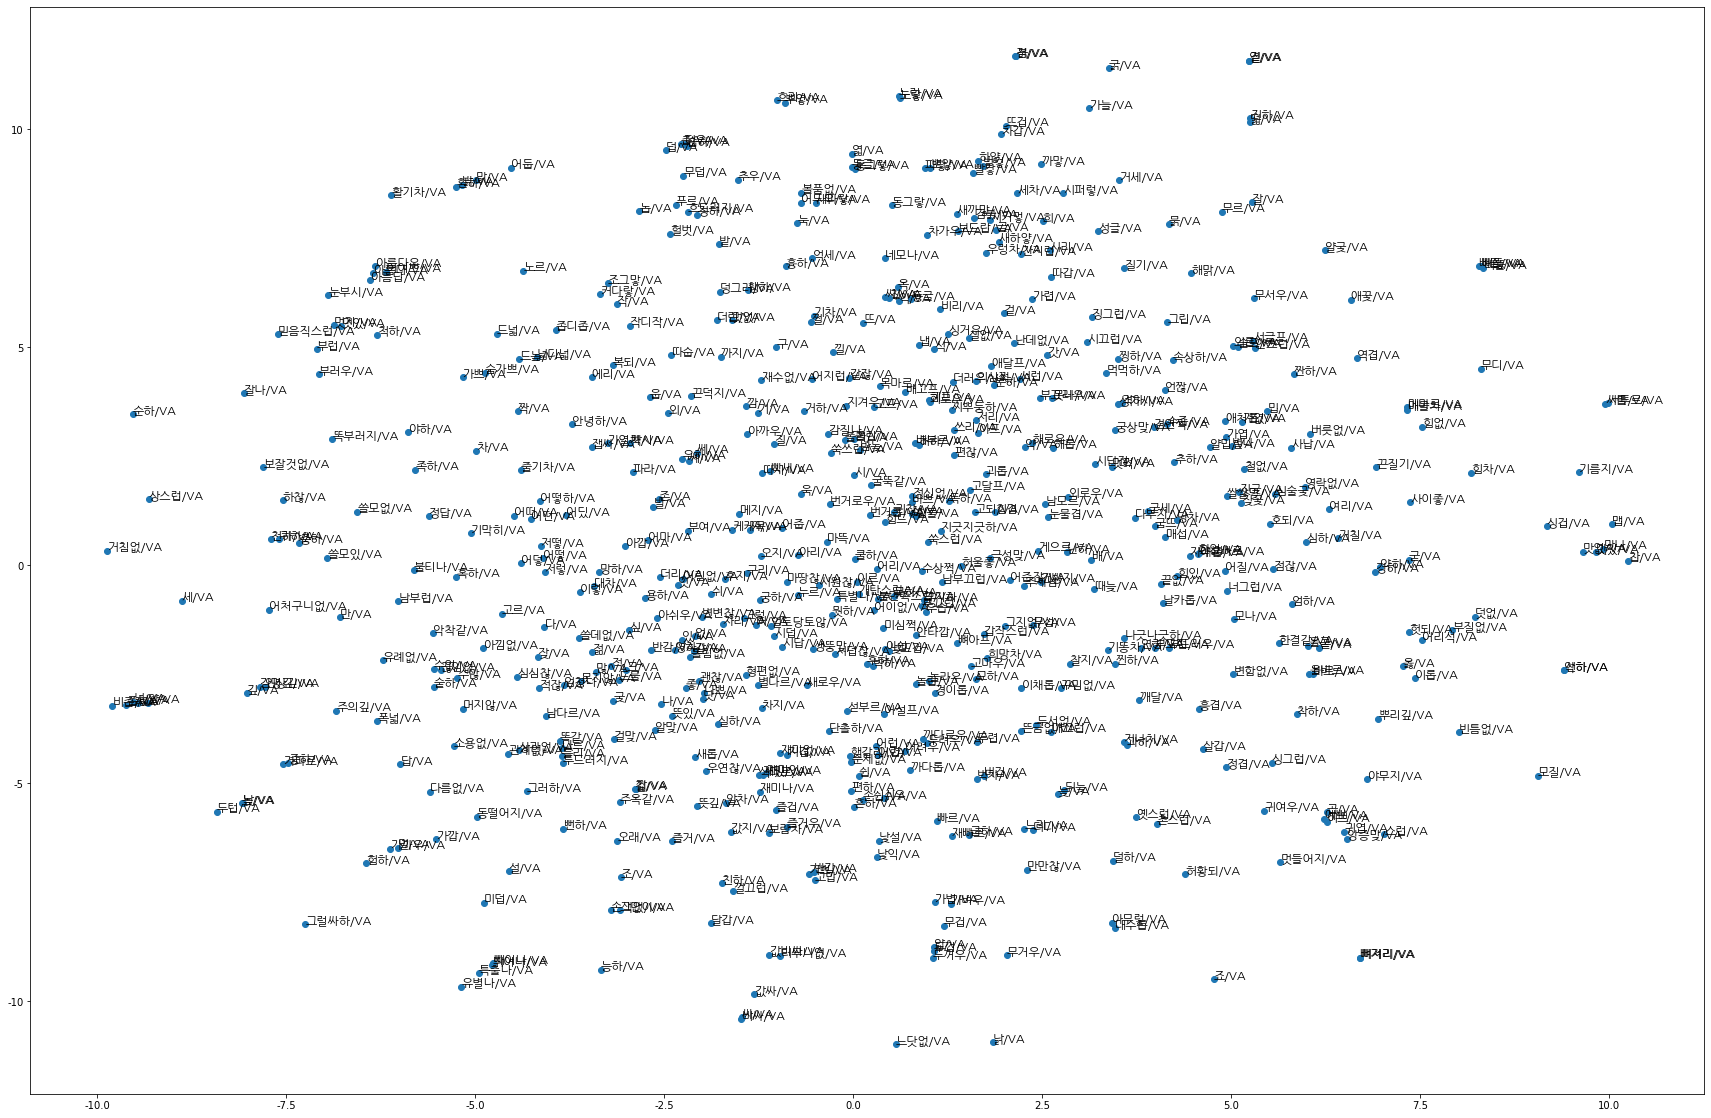

In [42]:
##### Draw figure
%matplotlib inline

fig = plt.figure()
fig.set_size_inches(30,20)

ax = fig.add_subplot(1, 1, 1)
ax.scatter(df["x"], df["y"])

prop = fm.FontProperties(fname = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf")
for word, pos in list(df.iterrows()):
  ax.annotate(word, pos, fontsize = 12, fontproperties = prop)

plt.show()